In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error

In [3]:
df=pd.read_csv('/content/Smart Home Dataset.csv')

df.head()
df.info()
print(df.isna().sum())

#eksik veri çok az olduğu için doldurmak yerine kaldırdım.
df.dropna(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12073 entries, 0 to 12072
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 12073 non-null  int64  
 1   use [kW]             12073 non-null  float64
 2   gen [kW]             12072 non-null  float64
 3   House overall [kW]   12072 non-null  float64
 4   Dishwasher [kW]      12072 non-null  float64
 5   Furnace 1 [kW]       12072 non-null  float64
 6   Furnace 2 [kW]       12072 non-null  float64
 7   Home office [kW]     12072 non-null  float64
 8   Fridge [kW]          12072 non-null  float64
 9   Wine cellar [kW]     12072 non-null  float64
 10  Garage door [kW]     12072 non-null  float64
 11  Kitchen 12 [kW]      12072 non-null  float64
 12  Kitchen 14 [kW]      12072 non-null  float64
 13  Kitchen 38 [kW]      12072 non-null  float64
 14  Barn [kW]            12072 non-null  float64
 15  Well [kW]            12072 non-null 

In [4]:
# time sütununu datetime formatına çevirip data_obj adlı sütunda tutulsun
df['date_obj'] = pd.to_datetime(df['time'])

df['hour'] = df['date_obj'].dt.hour           # Saat (0-23)
df['day_of_week'] = df['date_obj'].dt.dayofweek # Haftanın günü (Pzt=0, Paz=6)
df['month'] = df['date_obj'].dt.month

In [5]:
kaldirilacak_sutunlar = ['time', 'date_obj', 'summary', 'cloudCover']
df_clean = df.drop(kaldirilacak_sutunlar, errors='ignore')

# 1 saat önceki tüketim hesabı
df_clean['Last_1_Hour_Consumption'] = df_clean['House overall [kW]'].shift(1)

# 24 saat önceki tüketim hesabı (Dün aynı saatte ne oldu?)
df_clean['Last_24_Hour_Consumption'] = df_clean['House overall [kW]'].shift(24)

# shift işlemi yaptığımız için ilk 24 satırda NaN (boşluk) oluşur. Onları siliyoruz.
df_clean = df_clean.dropna()

In [6]:
# Pivot tabloyu oluşturacağız (Referans noktamız olacak)
# Satırlarda 'hour' (saat), Sütunlarda 'icon' (hava durumu) olsun.
ozet_tablo = df_clean.groupby(['hour', 'icon'], as_index=False)['House overall [kW]'].mean()

# Karışıklık olmasın diye sütun ismini değiştiriyoruz (Target ile aynı isimde kalmasın)
ozet_tablo.rename(columns={'House overall [kW]': 'Baseline_Consumption'}, inplace=True)

print("Oluşturulan Referans Tablosu:")
df_final = pd.merge(df_clean, ozet_tablo, on=['hour', 'icon'], how='left')

# Kontrol edelim
df_final[['hour', 'icon', 'House overall [kW]', 'Baseline_Consumption']].head()

Oluşturulan Referans Tablosu:


,hour,icon,House overall [kW],Baseline_Consumption
0,0,clear-night,1.293167,1.134898
1,0,clear-night,1.546667,1.134898
2,0,clear-night,1.822350,1.134898
3,0,clear-night,2.642517,1.134898
4,0,clear-night,1.739350,1.134898


In [7]:
# Kategorik Veriyi (Icon) Sayısallaştırma (One-Hot Encoding)
# drop_first=True diyerek gereksiz kolon tekrarını önlüyoruz.
df_encoded = pd.get_dummies(df_final, columns=['icon'], drop_first=True)

# Hedef (Target) ve Özellikleri (Features) Ayırma
# Sızıntı yaratacak cihaz bazlı tüm sütunları listeden çıkarıyoruz
exclude_cols = [
    'House overall [kW]', 'Dishwasher [kW]', 'Furnace 1 [kW]', 'Furnace 2 [kW]',
    'Home office [kW]', 'Fridge [kW]', 'Wine cellar [kW]', 'Garage door [kW]',
    'Kitchen 12 [kW]', 'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]',
    'Well [kW]', 'Microwave [kW]', 'Living room [kW]', 'Solar [kW]',
    'gen [kW]', 'use [kW]',
    'time', 'date_obj', 'summary', 'cloudCover'
]

# Girdiler
X = df_encoded.drop(columns=exclude_cols)
# Hedef (Tahmin edilecek)
y = df_encoded['House overall [kW]']

# Eğitim ve Test Setine Bölme (%80 Eğitim, %20 Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard Scaler (Ölçeklendirme)
# Scaler'ı sadece Train setine 'fit' edip sonra herkese 'transform' uyguluyoruz.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
model = RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

model2=KNeighborsRegressor(n_neighbors=5,n_jobs=-1)
model2.fit(X_train_scaled,y_train)
knn_pred=model2.predict(X_test_scaled)

In [9]:
# Başarı metriklerini kullanarak ie sonucu görelim ve değerlendirelim

results = {
    "Random Forest": {"R2": r2_score(y_test, y_pred), "MAE": mean_absolute_error(y_test, y_pred)},
    "KNN (Scaled)": {"R2": r2_score(y_test, knn_pred), "MAE": mean_absolute_error(y_test, knn_pred)}
}

print(results)

{'Random Forest': {'R2': 0.7782361440756113, 'MAE': 0.18877584060045643}, 'KNN (Scaled)': {'R2': 0.7821643702751465, 'MAE': 0.19516953942024898}}


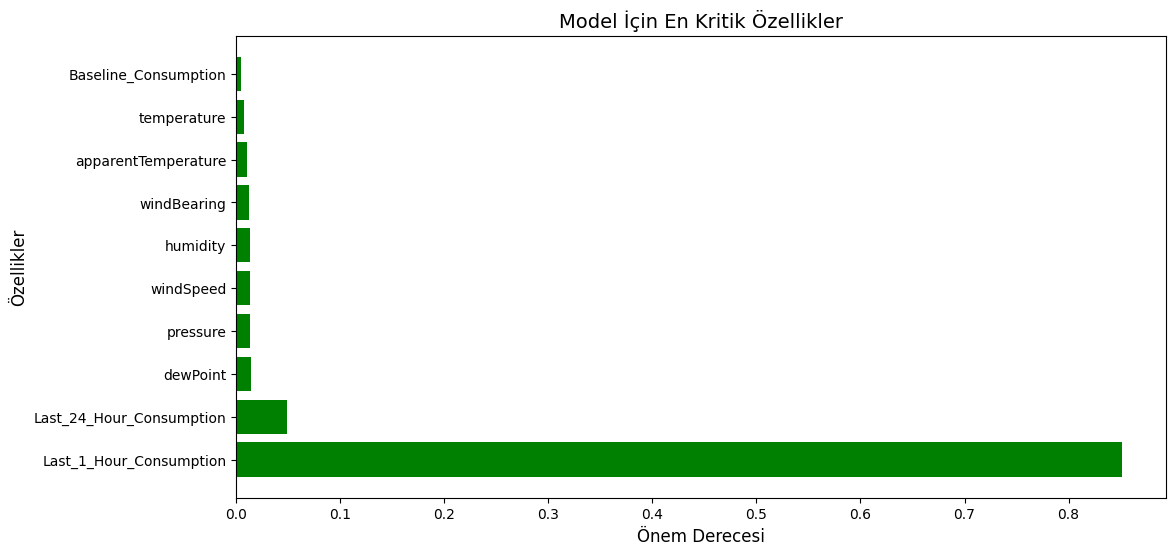

In [11]:
# Random Forest modelinden özellik önemlerini alıyoruz
importances = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1] # Büyükten küçüğe sırala


# Sadece en önemli 10 özelliği gösterelim
top_n = 10
plt.figure(figsize=(12, 6))

plt.barh(range(top_n), importances[indices][:top_n], align='center', color='green')
plt.yticks(range(top_n), [feature_names[i] for i in indices][:top_n])
plt.title('Model İçin En Kritik Özellikler', fontsize=14)
plt.xlabel('Önem Derecesi', fontsize=12)
plt.ylabel('Özellikler', fontsize=12)
plt.show()